Every stock market investor knows the pain of stock fluctuation, since predicting the stock market's direction is one of the hardest thing to do. There are many factors involved, from overall economy performance or company's fundamentals to news catalysts or market makers' manipulation. As an investor, I am interested to figure out if Machine Learning algorithms have the potential to unearth patterns in the stock market that human cannot detect, which can be used to improve the accuracy of stock prediction. In this project, I perform stock price prediction by applying Machine Learning algorithms on historical data of some stocks and indexes.

In [347]:
import pandas as pd
import numpy as np

I process the data from Yahoo Finance by computing MACD histogram and RSI, trying to be able to better predict the stock price based on two popular stock price indicators.

In [348]:
#First, make prediction on AAPL
apple = pd.read_csv("AAPL.csv")

In [349]:
print(apple.head())

        Date       Open       High        Low      Close  Adj Close  \
0  9/11/2015  27.947500  28.552500  27.940001  28.552500    26.3858   
1  9/14/2015  29.145000  29.222500  28.715000  28.827499    26.6399   
2  9/15/2015  28.982500  29.132500  28.605000  29.070000    26.8640   
3  9/16/2015  29.062500  29.135000  28.860001  29.102501    26.8940   
4  9/17/2015  28.915001  29.122499  28.430000  28.480000    26.3188   

      Volume  12-day EMA  26-day EMA  MACD line  Signal line  MACD histogram  \
0  199662000         NaN         NaN        NaN          NaN             NaN   
1  233453600         NaN         NaN        NaN          NaN             NaN   
2  173364800         NaN         NaN        NaN          NaN             NaN   
3  148694000         NaN         NaN        NaN          NaN             NaN   
4  256450400         NaN         NaN        NaN          NaN             NaN   

       Up    Down  SMA Up  SMA Down  RS  RSI  
0     NaN     NaN     NaN       NaN NaN  NaN 

There are some NaN cells, due to the fact that Moving Average cannot be calculated for several first data. I will access the issue when cleaning data later.

In [350]:
print(apple.shape)

(1259, 18)


I will use Adj Close price to account for adjustments in splits and dividend distributions. Source: https://help.yahoo.com/kb/SLN28256.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS91cmw_c2E9dCZyY3Q9aiZxPSZlc3JjPXMmc291cmNlPXdlYiZjZD0mdmVkPTJhaFVLRXdqcW85am1zdVByQWhVb3pJc0JIYks3REprUUZqQUJlZ1FJRHhBRiZ1cmw9aHR0cHMlM0ElMkYlMkZoZWxwLnlhaG9vLmNvbSUyRmtiJTJGU0xOMjgyNTYuaHRtbCZ1c2c9QU92VmF3M0JDVFBSWEdMOXZFNlRjVzJMZTk4bQ&guce_referrer_sig=AQAAAE5EHXcT_BbA5B0fN0i65rRVe3O7WGuETD-WdfvFS0q-mUbi5ZhdmrlGiq2feY3mkADxaIC62JkOSYd5Q4L2qCH07SyUw-4kG5jOkcBoR81SMGjPL4VbIBhhldraQaPWq-oOguw1DN4goSGS-4njyo5xrYB1bGU6cEvEqiwHfezO

In [351]:
#set date to correct format
import datetime
apple['Year'] = pd.to_datetime(apple.Date,format='%m/%d/%Y')
apple.index=apple['Year']
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

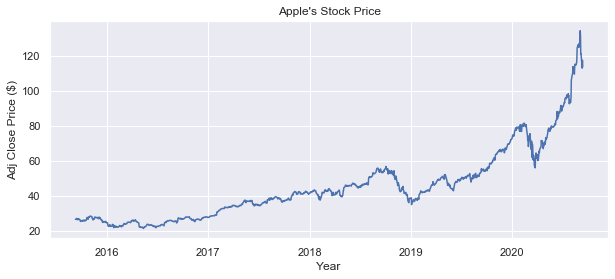

In [352]:
#Visualize historical price
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(10, 4))
plt.title("Apple's Stock Price")
plt.xlabel("Year")
plt.ylabel("Adj Close Price ($)")
plt.plot(apple["Adj Close"])
plt.show()

In [353]:
#Set up X as features and y as target object
y = apple["Adj Close"]
features = ['Open', 'High', 'Low', 'Volume', 'MACD histogram', 'RSI']
X = apple[features]

In [354]:
#split data into train and validation sets. Since this data is stock price, I split 1105 first rows (85% of total value) as 
#train and the rest as validation
train = apple[:1105]
valid = apple[1105:]

X_train = train[features]
y_train = train['Adj Close']
X_val = valid[features]
y_val = valid['Adj Close']

In [355]:
# shapes of training set
print('\n Shape of training set:')
print(X_train.shape)
print(y_train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(X_val.shape)
print(y_val.shape)


 Shape of training set:
(1105, 6)
(1105,)

 Shape of validation set:
(154, 6)
(154,)


In [356]:
#Cleaning Data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

MACD histogram    33
RSI               14
dtype: int64


In [357]:
#There are missing data in MACD histogram and RSI, since I cannot calculate the exponantial and simple moving average for the 
#beginning of the data. I will clean the missing data using imputation.

In [358]:
#Check Mean Absolute Error (on RandomForestRegressor) to figure out the best imputation strategy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
def score_dataset(X_train, X_val, y_train, y_val):
    model = RandomForestRegressor(n_estimators=100, random_state=1)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return mean_absolute_error(y_val, preds)

#Use Imputation. Only need to use on X_train, since X_val only contains data at the end of the dataset
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns

print("MAE (Imputation):")
print(score_dataset(imputed_X_train, X_val, y_train, y_val))
#SimpleImputer(strategy = 'median') gives the lowest MEA for Decision Tree, so I will try applying this to clean missing data

MAE (Imputation):
10.60351212337663


In [359]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

In [360]:
# Model - First, I will use Decision Tree algorithm
apple_dt = DecisionTreeRegressor(random_state=1)
# Fit Model
apple_dt.fit(imputed_X_train, y_train)
# Prediction
val_predictions = apple_dt.predict(X_val)

In [361]:
# Calculate mean absolute error
val_mae = mean_absolute_error(val_predictions, y_val)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

Validation MAE when not specifying max_leaf_nodes: 10


In [362]:
#Comparing different tree size to see if any tree size is better than when not specifying one
def get_mae(max_leaf_nodes, imputed_X_train, X_val, y_train, y_val):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(imputed_X_train, y_train)
    preds_val = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds_val)
    return(mae)
candidate_max_leaf_nodes = [5, 10, 30, 45, 50, 100, 500, 10000]
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
for max_leaf_nodes in candidate_max_leaf_nodes:
    my_mae = get_mae(max_leaf_nodes, imputed_X_train, X_val, y_train, y_val)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5  		 Mean Absolute Error:  18
Max leaf nodes: 10  		 Mean Absolute Error:  13
Max leaf nodes: 30  		 Mean Absolute Error:  11
Max leaf nodes: 45  		 Mean Absolute Error:  11
Max leaf nodes: 50  		 Mean Absolute Error:  10
Max leaf nodes: 100  		 Mean Absolute Error:  10
Max leaf nodes: 500  		 Mean Absolute Error:  10
Max leaf nodes: 10000  		 Mean Absolute Error:  10


In [363]:
#Specifying max_leaf_nodes to be at least 50 would give about the same result of not specifying max_leaf_nodes
apple_dt = DecisionTreeRegressor(max_leaf_nodes=50, random_state=1)
apple_dt.fit(imputed_X_train, y_train)
val_predictions = apple_dt.predict(X_val)
val_mae = mean_absolute_error(y_val,val_predictions)
print("MEA for best max_leaf_nodes:")
print(val_mae)

MEA for best max_leaf_nodes:
10.490951367026877


C:\Users\Minh Vo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


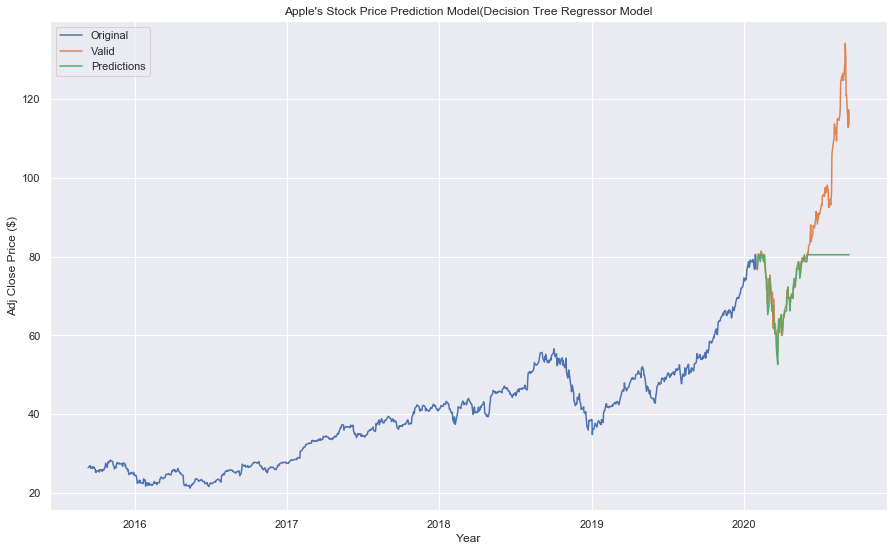

In [364]:
#Visualizing Decision Tree prediction
valid['Predictions'] = val_predictions
plt.figure(figsize=(15, 9))
plt.title("Apple's Stock Price Prediction Model(Decision Tree Regressor Model")
plt.xlabel("Year")
plt.ylabel("Adj Close Price ($)")
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','Predictions']])
plt.legend(["Original", "Valid", "Predictions"])
plt.show()

DecisionTreeRegressor makes solid predictions! However, the downside is that Decision Tree does not have enough information to predict the stock prices in validating dataset that are higher than the maximun stock price in training dataset.

In [365]:
#Next, I will apply Random Forest algorithm
apple_rf = RandomForestRegressor(random_state=1)
apple_rf.fit(imputed_X_train,y_train)
val_prediction = apple_rf.predict(X_val)

C:\Users\Minh Vo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [366]:
apple_val_mae = mean_absolute_error(y_val,apple_rf.predict(X_val))
#Calculating MEA
print("Validation MAE for Random Forest Model: {}".format(apple_val_mae))

Validation MAE for Random Forest Model: 10.508806363636364


In [367]:
#MAE comparison between Decision Tree and Random Forest: both algorithms give about the same MAE in this model.

C:\Users\Minh Vo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


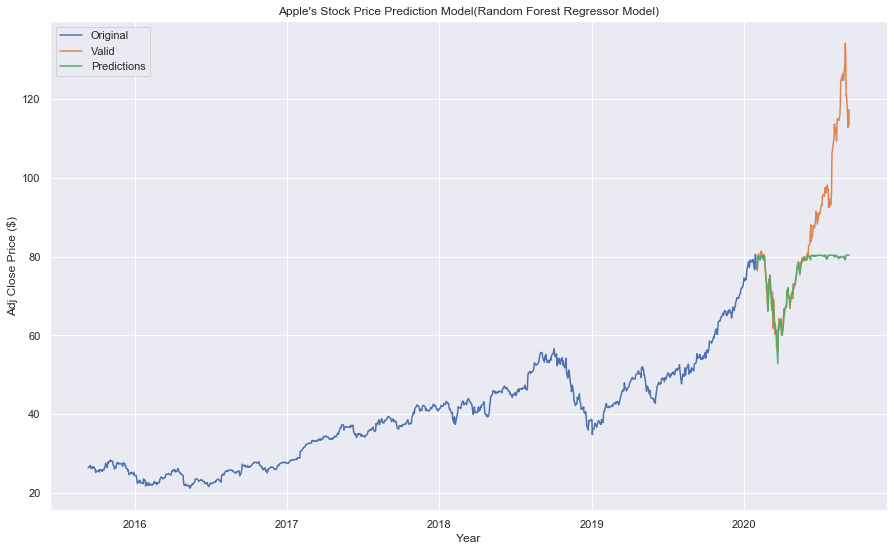

In [368]:
#Visualizing Random Forest prediction
valid['Predictions_rf'] = apple_rf.predict(X_val)
plt.figure(figsize=(15, 9))
plt.title("Apple's Stock Price Prediction Model(Random Forest Regressor Model)")
plt.xlabel("Year")
plt.ylabel("Adj Close Price ($)")
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','Predictions_rf']])
plt.legend(["Original", "Valid", "Predictions"])
plt.show()

As we can see, Random Forest can make solid predictions as well. However, it faces the same problem as Decision Tree; that is, it cannot predict the stock prices in validating dataset that are higher than the maximun stock price in training dataset.

To continue, I will apply the two Machine Learning algorithms on other stocks or indexes. Dow Jones index to go next.

In [369]:
dow = pd.read_csv("Dow Jones 30.csv")

In [370]:
print(dow.head())

        Date         Open         High          Low        Close    Adj Close  \
0  9/14/2015  16450.85938  16450.85938  16330.87012  16370.95996  16370.95996   
1  9/15/2015  16382.58008  16644.10938  16382.58008  16599.84961  16599.84961   
2  9/16/2015  16599.50977  16755.98047  16593.90039  16739.94922  16739.94922   
3  9/17/2015  16738.08008  16933.42969  16639.92969  16674.74023  16674.74023   
4  9/18/2015  16674.74023  16674.74023  16343.75977  16384.58008  16384.58008   

      Volume  12-day EMA  26-day EMA  MACD line  Signal line  MACD histogram  \
0   92660000         NaN         NaN        NaN          NaN             NaN   
1   93050000         NaN         NaN        NaN          NaN             NaN   
2   99620000         NaN         NaN        NaN          NaN             NaN   
3  129600000         NaN         NaN        NaN          NaN             NaN   
4  341690000         NaN         NaN        NaN          NaN             NaN   

           Up        Down  SMA U

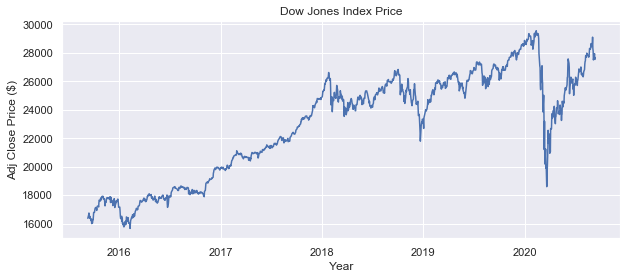

In [386]:
#set date to correct format
import datetime
dow['Year'] = pd.to_datetime(dow.Date,format='%m/%d/%Y')
dow.index=apple['Year']
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#Visualize historical price
sns.set()
plt.figure(figsize=(10, 4))
plt.title("Dow Jones Index Price")
plt.xlabel("Year")
plt.ylabel("Adj Close Price ($)")
plt.plot(dow["Adj Close"])
plt.show()

In [387]:
#Set up X as features and y as target object
y = dow["Adj Close"]
features = ['Open', 'High', 'Low', 'Volume', 'MACD histogram', 'RSI']
X = dow[features]

In [388]:
#split data into train and validation sets.
train = dow[:1105]
valid = dow[1105:]

X_train = train[features]
y_train = train['Adj Close']
X_val = valid[features]
y_val = valid['Adj Close']

In [389]:
# shapes of training set
print('\n Shape of training set:')
print(X_train.shape)
print(y_train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(X_val.shape)
print(y_val.shape)


 Shape of training set:
(1105, 6)
(1105,)

 Shape of validation set:
(154, 6)
(154,)


In [390]:
#Cleaning Data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

MACD histogram    33
RSI               14
dtype: int64


In [391]:
#Check Mean Absolute Error (on RandomForestRegressor) to figure out the best imputation strategy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
def score_dataset(X_train, X_val, y_train, y_val):
    model = RandomForestRegressor(n_estimators=100, random_state=1)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return mean_absolute_error(y_val, preds)

#Use Imputation. Only need to use on X_train, since X_val only contains data at the end of the dataset
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'constant')
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns

print("MAE (Imputation):")
print(score_dataset(imputed_X_train, X_val, y_train, y_val))
#SimpleImputer(strategy = 'constant') gives the lowest MEA for Decision Tree, so I will try applying this to clean missing data

MAE (Imputation):
190.87672684545478


In [392]:
# Model - First, I will use Decision Tree algorithm
dow_dt = DecisionTreeRegressor(random_state=1)
# Fit Model
dow_dt.fit(imputed_X_train, y_train)
# Prediction
val_predictions = dow_dt.predict(X_val)

In [393]:
val_mae = mean_absolute_error(val_predictions, y_val)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

Validation MAE when not specifying max_leaf_nodes: 228


In [394]:
#Comparing different tree size to see if any tree size is better than when not specifying one
def get_mae(max_leaf_nodes, imputed_X_train, X_val, y_train, y_val):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(imputed_X_train, y_train)
    preds_val = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds_val)
    return(mae)
candidate_max_leaf_nodes = [5, 10, 55, 56, 57, 58, 100, 500, 1000]
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
for max_leaf_nodes in candidate_max_leaf_nodes:
    my_mae = get_mae(max_leaf_nodes, imputed_X_train, X_val, y_train, y_val)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5  		 Mean Absolute Error:  667
Max leaf nodes: 10  		 Mean Absolute Error:  503
Max leaf nodes: 55  		 Mean Absolute Error:  222
Max leaf nodes: 56  		 Mean Absolute Error:  213
Max leaf nodes: 57  		 Mean Absolute Error:  213
Max leaf nodes: 58  		 Mean Absolute Error:  215
Max leaf nodes: 100  		 Mean Absolute Error:  216
Max leaf nodes: 500  		 Mean Absolute Error:  223
Max leaf nodes: 1000  		 Mean Absolute Error:  223


In [395]:
#Specifying max_leaf_nodes to be 56 would give better result than not specifying max_leaf_nodes
apple_dt = DecisionTreeRegressor(max_leaf_nodes=56, random_state=1)
apple_dt.fit(imputed_X_train, y_train)
val_predictions = apple_dt.predict(X_val)
val_mae = mean_absolute_error(y_val,val_predictions)
print("MEA for best max_leaf_nodes:")
print(val_mae)

MEA for best max_leaf_nodes:
212.06950820547277


C:\Users\Minh Vo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


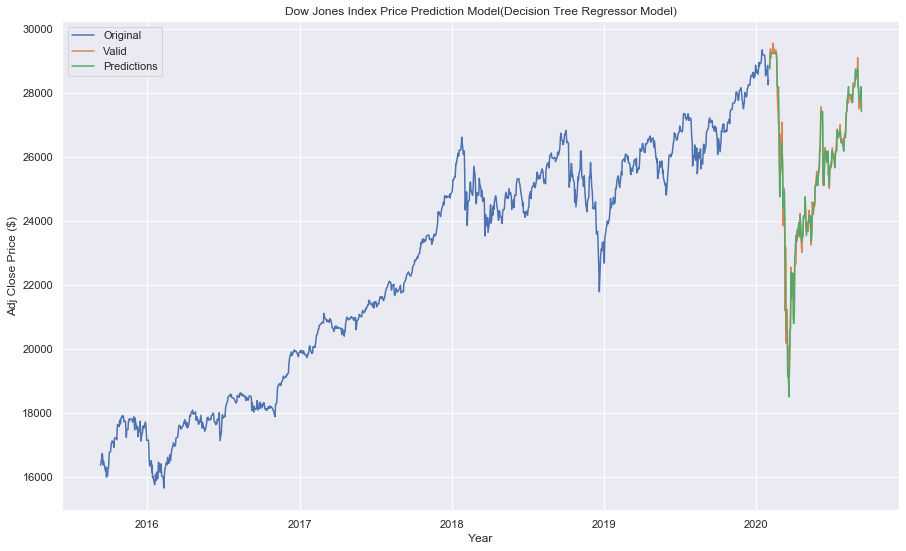

In [396]:
#Visualizing Decision Tree prediction
valid['Predictions'] = val_predictions
plt.figure(figsize=(15, 9))
plt.title("Dow Jones Index Price Prediction Model(Decision Tree Regressor Model)")
plt.xlabel("Year")
plt.ylabel("Adj Close Price ($)")
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','Predictions']])
plt.legend(["Original", "Valid", "Predictions"])
plt.show()

So, with stock (or index) prices where validation prices are not higher than the maximum price in training dataset, Decision Tree prediction is really powerful!

In [397]:
#Next, I will apply Random Forest algorithm
dow_rf = RandomForestRegressor(random_state=1)
dow_rf.fit(imputed_X_train,y_train)
val_prediction = dow_rf.predict(X_val)

C:\Users\Minh Vo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [398]:
dow_val_mae = mean_absolute_error(y_val,dow_rf.predict(X_val))
#Calculating MEA
print("Validation MAE for Random Forest Model: {}".format(dow_val_mae))

Validation MAE for Random Forest Model: 189.0973996753243


In [399]:
#MAE comparison between Decision Tree and Random Forest: Random Forest gives slightly lower MAE, meaning Random Forest fits 
#this model more.

C:\Users\Minh Vo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


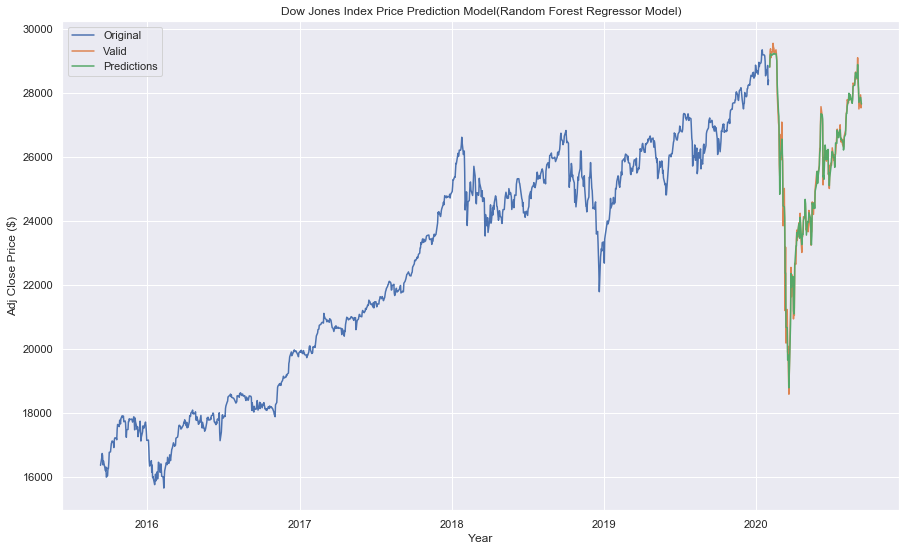

In [400]:
#Visualizing Random Forest prediction
valid['Predictions_rf'] = dow_rf.predict(X_val)
plt.figure(figsize=(15, 9))
plt.title("Dow Jones Index Price Prediction Model(Random Forest Regressor Model)")
plt.xlabel("Year")
plt.ylabel("Adj Close Price ($)")
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','Predictions_rf']])
plt.legend(["Original", "Valid", "Predictions"])
plt.show()

Random Forest is also a powerful algorithm here. Based on MAE, it is slightly better than Decision Tree in this case.

However, as mentioned in the beginning, keep in mind that stock (or index) prices are affected by news about the market or the company and by the company's fundamentals, so there are still a lot of possible factors that are not accounted for in this model.